In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import scipy.io

In [2]:
dataPath = r'/Users/hyx020222/Documents/GitHub/Passive-Handwriting-Tracking/data'
shapeType = 'eight'
shapePath = fr'{dataPath}/{shapeType}'
movPath = fr'{shapePath}/{shapeType}.mov'
matPath = fr'{shapePath}/{shapeType}.mat'

In [3]:
def extract_added_black_points(path):
    cap = cv2.VideoCapture(path)

    # 读取第一帧
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    added_black_points_sequence = []

    while True:
        # 读取下一帧
        ret, frame = cap.read()
        if not ret:
            break

        # 转换为灰度图
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 计算相邻帧的差异
        diff = cv2.absdiff(prev_gray, gray)

        # 通过阈值化得到黑点
        _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

        # 查找轮廓
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 提取新增黑点的坐标
        added_points = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 5:  # 考虑面积大于5的轮廓为新增黑点
                M = cv2.moments(contour)
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                added_points.append((cx, cy))

        added_black_points_sequence.append(added_points)

        # 更新上一帧
        prev_gray = gray

    cap.release()
    return added_black_points_sequence

In [4]:
sequence = extract_added_black_points(movPath)

# 删除空时刻
sequence = [points for points in sequence if points]
print(sequence)

[[(285, 130)], [(275, 130)], [(264, 132)], [(252, 135)], [(244, 137)], [(234, 139)], [(225, 142)], [(216, 144)], [(205, 148)], [(199, 151)], [(186, 156)], [(175, 160)], [(166, 165)], [(158, 169)], [(146, 175)], [(143, 178)], [(133, 187)], [(120, 197)], [(112, 205)], [(106, 212)], [(100, 219)], [(90, 233)], [(84, 241)], [(79, 249)], [(75, 257)], [(69, 269)], [(63, 280)], [(60, 288)], [(56, 300)], [(53, 310)], [(52, 319)], [(51, 329)], [(50, 343)], [(50, 353)], [(52, 361)], [(56, 374)], [(59, 382)], [(65, 393)], [(72, 404)], [(79, 415)], [(85, 422)], [(96, 434)], [(103, 442)], [(113, 452)], [(123, 461)], [(140, 474)], [(148, 479)], [(165, 488)], [(186, 497)], [(201, 504)], [(219, 511)], [(238, 519)], [(252, 524)], [(275, 532)], [(295, 539)], [(312, 545)], [(333, 553)], [(352, 560)], [(365, 565)], [(393, 575)], [(414, 583)], [(425, 587)], [(447, 596)], [(468, 607)], [(484, 617)], [(503, 632)], [(523, 648)], [(531, 656)], [(550, 674), (536, 660)], [(559, 685)], [(568, 698)], [(582, 722)], 

In [5]:
### Transform tuple into list ###
pointList = []

cnt = 0
for points in tqdm(sequence):
    xThis, yThis = zip(*points)
    xThis = int(xThis[0])
    yThis = int(yThis[0])

    # Check if this point is abnormally far from last point
    if cnt > 0:
        xLast = pointList[-1][0]
        yLast = pointList[-1][1]
        if math.sqrt((xThis - xLast)**2 + (yThis - yLast)**2) > 50:
            continue

    pointList.append([xThis, yThis])

    cnt += 1

print(pointList)

# 提取 x 和 y 坐标
xPoint, yPoint = zip(*pointList)

100%|██████████| 176/176 [00:00<00:00, 533379.70it/s]

[[285, 130], [275, 130], [264, 132], [252, 135], [244, 137], [234, 139], [225, 142], [216, 144], [205, 148], [199, 151], [186, 156], [175, 160], [166, 165], [158, 169], [146, 175], [143, 178], [133, 187], [120, 197], [112, 205], [106, 212], [100, 219], [90, 233], [84, 241], [79, 249], [75, 257], [69, 269], [63, 280], [60, 288], [56, 300], [53, 310], [52, 319], [51, 329], [50, 343], [50, 353], [52, 361], [56, 374], [59, 382], [65, 393], [72, 404], [79, 415], [85, 422], [96, 434], [103, 442], [113, 452], [123, 461], [140, 474], [148, 479], [165, 488], [186, 497], [201, 504], [219, 511], [238, 519], [252, 524], [275, 532], [295, 539], [312, 545], [333, 553], [352, 560], [365, 565], [393, 575], [414, 583], [425, 587], [447, 596], [468, 607], [484, 617], [503, 632], [523, 648], [531, 656], [550, 674], [559, 685], [568, 698], [582, 722], [586, 733], [594, 753], [596, 763], [601, 785], [602, 798], [603, 808], [603, 834], [601, 844], [595, 872], [590, 885], [581, 907], [573, 924], [563, 944], 

In [6]:
### Rotate for pi ###
# 将点列表转换为NumPy数组以便于计算
points_array = np.array(pointList)

# 计算重心
centroid = np.mean(points_array, axis=0)
# 将每个点相对于重心进行旋转180度
rotated_points = 2 * centroid - points_array

# 绘制旋转后的时序曲线
x_rotated, y_rotated = rotated_points.T
# 合并x和y坐标成一个完整的点列表
rotatedList = list(zip(x_rotated.tolist(), y_rotated.tolist()))

print(rotatedList)

[(323.51724137931035, 921.6896551724137), (333.51724137931035, 921.6896551724137), (344.51724137931035, 919.6896551724137), (356.51724137931035, 916.6896551724137), (364.51724137931035, 914.6896551724137), (374.51724137931035, 912.6896551724137), (383.51724137931035, 909.6896551724137), (392.51724137931035, 907.6896551724137), (403.51724137931035, 903.6896551724137), (409.51724137931035, 900.6896551724137), (422.51724137931035, 895.6896551724137), (433.51724137931035, 891.6896551724137), (442.51724137931035, 886.6896551724137), (450.51724137931035, 882.6896551724137), (462.51724137931035, 876.6896551724137), (465.51724137931035, 873.6896551724137), (475.51724137931035, 864.6896551724137), (488.51724137931035, 854.6896551724137), (496.51724137931035, 846.6896551724137), (502.51724137931035, 839.6896551724137), (508.51724137931035, 832.6896551724137), (518.5172413793103, 818.6896551724137), (524.5172413793103, 810.6896551724137), (529.5172413793103, 802.6896551724137), (533.5172413793103

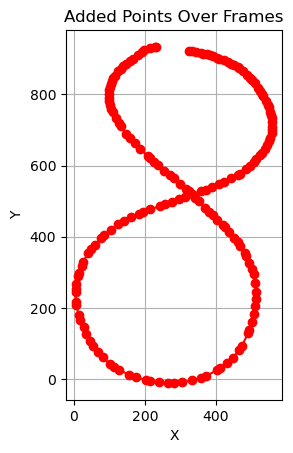

In [7]:
fig, ax = plt.subplots()

plt.plot(x_rotated, y_rotated, 
         marker='o', 
         linestyle='-', 
         color='r')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Added Points Over Frames')
ax.grid(True)
ax.axes.set_aspect('equal')
plt.show()